# FRTB-SA: sensitivities-based method - Equities

**Introduction:<br>**
This notebook contains the implementation of FRTB-SA for market risk capital requirements. More specifically, the BCBS guidelines as of January 2019 were used (publication number 457; link of document bellow). The section on FRTB-SA for market risk is presented in detail under section 21: "MAR21 Standardised Approach: Sensitivities-based Method".

<u>Source</u> : https://www.bis.org/bcbs/publ/d457_faq.pdf (MAR21)

**Author:** <br>
This Notebook (implementation and analysis) is the work and property of Joshua KAJI - FRM. All Rights reserved.

**Structure of the document:**<br>
The notebook is structured to facilitate comprehension of the methodology, both in terms of implementation and description. Each code cell is preceded by an explanatory note outlining the tasks undertaken, as well as the subsection reference (eg: MAR21.XX) to which it relates in the regulatory documentation. 

**Table of Content:**
1) [Defining buckets](#section1)
2) [Defining Risk Factors within buckets](#section2)
3) [Intra-bucket correlation](#section3)
4) [Inter-bucket correlation](#section4)
5) [aggregating within and across buckets (Kb, Sb, Delta, Vega, Curvature)](#section5)
6) [Computing total capital charge (max correlation scenario)](#section6)
7) [Computing total capital charge (max correlation scenario)](#section7)
8) [Decomposing Instruments into RFs](#section8)
9) [Testing with hypothetical portfolios](#section9)<br>
    9.1 [portfolio 1 - long call](#section10)<br>
    9.2 [portfolio 2 - short call](#section11)<br>
    9.3 [Portfolio 3 : long call (BNP), long call (SG) ](#section12)<br>
    9.4 [Portfolio 4 : long call (BNP) ,short call (SG)](#section13)<br>
    9.5 [Portfolio 5 : long call (BNP) ,long call (TOTAL) ](#section14)<br>






## <a id="section1"></a> 1) Defining buckets
First step is defining the RWs for equity asset class. RWs correspond to the shock/movement that will be applied to the underlying (for equities: spot or repo).
<details>
  <summary>[MAR21.72] : Delta buckets according to the underlying spot/repo</summary>
  <img src="extracted_images/image - 22.png" alt="image"  width="600" />
</details>

<details>
  <summary>[MAR21.77] : RWs according to bucket and RF type (ie: spot or repo rate)</summary>
  <img src="extracted_images/image - 2.png" alt="image"  width="600" />
</details>


<details>
  <summary>[MAR21.6] : 3 correlation scenarios must be used(-25%, +0%, +25% : applied to rho and gamma) </summary>
  <img src="extracted_images/image - 1.png" alt="image"  width="600" />
</details>


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Aug 24 08:23:07 2024

@author: joshuakaji
"""

import pandas as pd 
import numpy as np
import os 
#print(os.getcwd())
from pricing_functions import *
from collections import defaultdict
import copy

# [MAR21.77] : define buckets of equity RFs:
RW_map = pd.DataFrame(columns = ["bucket", "spot", "repo"], index = [i for i in range(1, 14)])

RW_map["bucket"] = [i for i in range(1, 14)]
RW_map["spot"] = [55, 60, 45, 55, 30, 35, 40, 50, 70, 50, 70, 15, 25]
RW_map["repo"] = RW_map["spot"] /100

# correlation scenario takes values : 1, 0.75, 1.25
corr_sce = 1

## <a id="section2"></a> 2) Defining RFs within buckets 
We define the risk factor class with the necessary information such that we are able to:

- Net against positions with same RF exposure
  - Same {name X RF type} netting Delta exposures (e.g., {"Tesla", spot})
  - Same {name X term} for calculating Vega for options (e.g., {"Tesla", 3M})
  - Same name for calculating CVR+ and CVR-
- Aggregate within buckets
- Aggregate across buckets

Note : 
- we overload the "^" (ie: XOR) opperator to an "intra buncket correlation" opperator.
- we overload the "+" (ie: ADD) opperator to sum sensitivities (legal only when same netting allowed).



<details>
  <summary>[MAR21.12] : Equity RF definitions for Delta, Vega and Curvature </summary>
  <img src="extracted_images/image - 3.png" alt="image"  width="700" />
</details>


In [5]:
class eqt_rf():
    def __init__(self, name, bucket, rf_type, sensi, T=np.nan):
        self.name = name
        #from 1 to 13
        self.bucket = bucket
        self.sensi = sensi
        self.rf_type = rf_type
        self.T = T # term of the option
        
    def __str__(self):
        return '\n' + self.name + "\nbucket : " +str(self.bucket) + "\nRF type : "  + self.rf_type + "\nRWA : " + str(self.sensi)
    
    # xor overload for intra bucket correlation
    def __xor__(self, other):
        return get_rho(self, other)
    
    def __add__(self, other):
        # Common
        if (self.rf_type == other.rf_type) & (self.bucket == other.bucket) & (self.name == other.name):
            # for Delta
            if (self.rf_type == 'delta_spot') | (self.rf_type == 'delta_repo'):
                rf_copy = copy.deepcopy(self)
                rf_copy.sensi += other.sensi
                return rf_copy 
            # for Vega
            if (self.rf_type == 'vega') & (self.T == other.T):
                rf_copy = copy.deepcopy(self)
                rf_copy.sensi += other.sensi
                return rf_copy
            # for Curvature
            elif (self.rf_type == 'curvature'):
                rf_copy = copy.deepcopy(self)
                rf_copy.sensi[0] += other.sensi[0]
                rf_copy.sensi[1] += other.sensi[1]
                return rf_copy
        raise TypeError('trying to sum non-compatible risk factors')

    def __radd__(self, other):
        if isinstance(other, int):
            return self
        return self.__add__(other)
    
    def __abs__(self):
        self.sensi = abs(self.sensi)
        return self


## <a id="section3"></a> 3) Intra-bucket correlation
We define "get_rho" function that takes 2 risk factors and returns their intra-correlation (MAR21.78). 
errors are returned when intra correlation between them is not meant to be calculated according to the methodology (eg: when risk factors are from different buckets).



<details>
  <summary>[MAR21.78] : Intra bucket correlation (for Delta) </summary>
  <img src="extracted_images/image - 7.png" alt="image"  width="700" />
</details>

<details>
  <summary>[MAR21.94] : Intra bucket correlation (for Vega) </summary>
  <img src="extracted_images/image - 4.png" alt="image" width="700" />
</details>


<details>
  <summary>[MAR21.93 (1)] : Option Intra-correlation (used for Vega aggregation within buckets) </summary>
  <img src="extracted_images/image - 5.png" alt="image"  width="700" />
</details>

<details>
  <summary>[MAR21.100] : Intra bucket correlation (for Curvature) </summary>
  <img src="extracted_images/image - 6.png" alt="image"  width="700" />
</details>



In [6]:
# [MAR21.78]
def get_rho(rf1, rf2):
    # [MAR21.78] - aggregating within bucket - delta equity 
    if (rf1.rf_type == 'delta_spot') | (rf1.rf_type == 'delta_repo') :
        if (rf1.name == rf2.name) & (rf1.rf_type != rf2.rf_type):
            rho = 0.999
        elif (rf1.name != rf2.name) & (rf1.rf_type != rf2.rf_type):
            rho = 0.999 * intraSecter_corr(rf1, rf2)
        elif (rf1.name != rf2.name) & (rf1.rf_type == rf2.rf_type):
            rho = intraSecter_corr(rf1, rf2)
        else:
            raise ValueError('Error : No match found when calling get_rho')
    # [21.94] : - aggregating within bucket - vega equity
    if rf1.rf_type == 'vega':
        rho_option_term = np.exp(-0.01 * abs(rf1.T - rf2.T)/min(rf1.T, rf2.T))
        if (rf1.name == rf2.name)& (rf1.T != rf2.T):
            rho = min(1 * rho_option_term, 1)
        elif (rf1.name != rf2.name):
            rho = min(intraSecter_corr(rf1, rf2) * rho_option_term, 1)
        else:
            raise ValueError('Error : No match found when calling get_rho')
    # [21.100] : - aggregating within bucket - curvature equity
    if rf1.rf_type == 'curvature':
        if rf1.name != rf2.name:
            rho = intraSecter_corr(rf1, rf2)**2
        else:
            raise ValueError('Error : No match found when calling get_rho')
    if corr_sce == 0.75:
        return max(2*rho-1, rho*corr_sce)  #[MAR21.6]
    return min(rho  * corr_sce, 1)


# [MAR21.78 (2)] intra-Sector correlation (for different names, same bucket)
def intraSecter_corr(rf1, rf2):
    if (rf1.bucket != rf2.bucket) | (rf1.name == rf2.name):
        raise ValueError('Error : calling intraSecter_corr on RF with same bucket or name ')
    bucket = rf1.bucket 
    if bucket in [1, 2, 3, 4, 5]:
        return 0.15
    elif bucket in [5, 6, 7, 8]:
        return 0.25
    elif bucket == 9:
        return 0.075
    elif bucket == 10:
        return 0.125
    elif bucket in [11, 12]:
        return 0.8
    

## <a id="section4"></a> 4) Inter-bucket correlation
We define "get_gamma" function that takes 2 risk factors and returns their Inter-correlation (MAR21.80).


<details>
  <summary>[MAR21.80] : Inter-bucket correlation (for Delta) </summary>
  <img src="extracted_images/image - 10.png" alt="image"  width="700" />
</details>

<details>
  <summary>[MAR21.95] : Inter-bucket correlation (for Vega) => same as delta </summary>
  <img src="extracted_images/image - 9.png" alt="image"  width="700" />
</details>

<details>
  <summary>[MAR21.101] : Inter-bucket correlation (for Curvature) => squared of delta</summary>
  <img src="extracted_images/image - 8.png" alt="image"  width="700" />
</details>


In [7]:
def get_gamma(b1, b2, for_curvature=False):
    set1 = list(range(1, 11)) # defined sectors exonomies and market caps 
    set2 = [11] # bucket others => zero correlation
    set3 = [12, 13] # indices
    # if both stocks 
    if (b1 in set1) & (b2 in set1):
        gamma = 0.15
    # if both indices 
    if (b1 in set3) & (b2 in set3):
        gamma = 0.75
    # if eiither one is bucket 11 (ie other)
    if (b1 in set2) | (b2 in set2):
        gamma = 0
    # if one is stock and the other index => correlation 45%
    if ((b1 in set1) & (b2 in set3)) | ((b2 in set1) & (b1 in set3)):
        gamma = 0.45
    if corr_sce == 0.75:
        return max(2*gamma-1, gamma*corr_sce) #[MAR21.6]
    return min(gamma*corr_sce, 1)
    
# print Gamma matrix
matrix = np.array([[get_gamma(i, j) if i!=j else None for j in range(1, 14)] for i in range(1, 14)])
gamma_matrix = pd.DataFrame(matrix, columns=range(1, 14), index=range(1, 14))
#print(np.matrix(matrix))
#print(gamma_matrix)



## <a id="section5"></a> 5) Allocation of RFs to buckets and netting identical exposures
"net_RWS" function takes a list of RFs and nets them against each other when possible. It returns a dictionary mapping the bucket to a list of netted risk factors (of that bucket).

Netting is allowed between RFs when they are identical with respect to the following parameters:
- {name X rf_type X bucket} for delta RFs (eg : {"aapl" X "repo" X 10}
- {name X maturity X bucket } for vega RFs
- {name X bucket} for Curvature RFs

<details>
  <summary>[21.5 (2)] : calculation of [CVR+, CVR-] for Curvature (this is done for each RF in a bucket) </summary>
  <img src="extracted_images/image - 11.png" alt="image"  width="700" />
</details>


In [8]:
# from a list of risk factors, allocate to correct bucket determine net RWSs
# must be a list of RFs from same sensitivity type (eg: all "Delta")
def net_RWS(L):
    # for DELTA
    L = copy.deepcopy(L)
    if (L[0].rf_type == 'delta_spot') | (L[0].rf_type == 'delta_repo'):    
        NRWS = {i: [] for i in range(1, 14)}
        for rf in L:
            found = False
            for i in range(len(NRWS[rf.bucket])):
                rf2 = NRWS[rf.bucket][i]
                if ((rf.name==rf2.name) & (rf.rf_type==rf2.rf_type)):
                    NRWS[rf.bucket][i] = rf2 + rf
                    found=True
                    break
            if not found:
                NRWS[rf.bucket].append(rf)

    # for VEGA
    if (L[0].rf_type == 'vega'):
        NRWS = {i: [] for i in range(1, 14)}
        for rf in L:
            found = False
            for i in range(len(NRWS[rf.bucket])):
                rf2 = NRWS[rf.bucket][i]
                if ((rf.name==rf2.name) & (rf.T==rf2.T)):
                    NRWS[rf.bucket][i] = rf2 + rf
                    found=True
                    break
            if not found:
                NRWS[rf.bucket].append(rf)
    # [21.5 (2) (f)] CURVATURE
    if (L[0].rf_type == 'curvature'):
        NRWS = {i: [] for i in range(1, 14)}
        for rf in L: 
            found = False
            for i in range(len(NRWS[rf.bucket])):
                rf2 = NRWS[rf.bucket][i]
                if (rf.name==rf2.name):
                    NRWS[rf.bucket][i] = rf2 + rf
                    found=True
                    break
            if not found:

                NRWS[rf.bucket].append(rf)
        # minus in front of aggredation ([21.5 (2) (f) (iii)])
        for b in NRWS.keys():
            for rf in NRWS[b]:
                rf.sensi[0] *= -1 
                rf.sensi[1] *= -1
    return NRWS



## <a id="section6"></a> 6) Aggregating within and across buckets (Kb, Sb)
"aggregate_buckets" function takes the output of "net_RWS" (ie: dictionary mapping buckets to the list of netted RFs of that bucket) and returns the capital charge for the sensitivity (ie: Delta, Vega or Curvature capital charge).

This is done by:
- computing Kb the intra-bucket aggregated capital charge for each bucket (using the rho : intra-bucket correlation matrix).
- computing Sb the intra-bucket aggregated capital charge for each bucket (using the Gamma : Inter bucket correlation matrix)
- aggregating the results using 

Calculating Kb (aggreagation within bucket)
<details>
  <summary>[21.4 (4)] : computing Kb for Delta and Vega </summary>
  <img src="extracted_images/image - 12.png" alt="image"  width="700" />
</details>

<details>
  <summary>[21.5 (3)] : calculation of Kb for Curvature (this is done for each RF in a bucket) </summary>
  <img src="extracted_images/image - 16.png" alt="image"  width="700" />
</details>
    Note : the scenarios (upwards/downwards) shock must be saved as it impacts the calculation of Sb.

<details>
  <summary>[21.79] : specific treatment for bucket 11 (ie: sector "other") </summary>
  <img src="extracted_images/image - 15.png" alt="image"  width="700" />
</details>
Note : This means there is no diversification benefit permitted for bucket 11. This is natural since we do not know the nature of the RFs in that bucket nor their relationship with each other. 

aggregating across bucket (of Kb and Sb)
<details>
  <summary>[21.4 (5)] : Aggregating Kb and Sb for Delta and Vega </summary>
  <img src="extracted_images/image - 13.png" alt="image"  width="700" />
</details>
<details>
  <summary>[21.5 (4)] : Aggregating Kb and Sb for Curvature </summary>
  <img src="extracted_images/image - 14.png" alt="image"  width="700" />
</details>

In [9]:
# from bucketed and netted RWS, aggregate first within each bucket, then across
def aggregate_buckets(NRWS):
    NRWS = copy.deepcopy(NRWS)
    Kb = {i : 0 for i in range(1, 14)}
    Sb = {i : 0 for i in range(1, 14)}

    # for delta
    sensi_type = None
    for b in range(1, 14):
        for rf in NRWS[b]:
            sensi_type = rf.rf_type
    # if empty
    if sensi_type is None:
        return Kb
    # Delta
    # [21.4 (4)] delta and vega aggregation within bucket
    elif (sensi_type == "delta_repo") |(sensi_type == "delta_spot"):
        # aggregate within bucket (ie: compute Kb)
        for b in [*range(1, 11), *[12, 13]]: 
            Kb[b] = np.sqrt(sum([ws.sensi**2 for ws in NRWS[b]]) + sum([ws1.sensi * ws2.sensi * get_rho(ws1, ws2) for ws1 in NRWS[b] for ws2 in NRWS[b] if ws1 != ws2]))
        # [21.79] Above does not apply to the "other" sector bucket (ie bucket 11).
        Kb[11] = sum([abs(ws.sensi) for ws in NRWS[11]]) 
        # compute Sb
        for b in Sb.keys(): 
            Sb[b] = sum([rf.sensi for rf in NRWS[b]])
        # [MAR21.4 (5)] 
        sum1 = sum(np.array(list(Kb.values()))**2)
        sum2 = sum([Sb[b1]*Sb[b2]*get_gamma(b1, b2) for b1 in Sb.keys() for b2 in Sb.keys() if b1 != b2])
        delta = np.sqrt(sum1 + sum2)
        return delta
    # Vega
    elif (sensi_type == "vega"):
        # aggregate within bucket (ie: compute Kb)
        for b in [*range(1, 11), *[12, 13]]: 
            Kb[b] = np.sqrt(sum([ws.sensi**2 for ws in NRWS[b]]) + sum([ws1.sensi * ws2.sensi * get_rho(ws1, ws2) for ws1 in NRWS[b] for ws2 in NRWS[b] if ws1 != ws2]))
        # analagous to delta treatment of bucket 11 (see [21.79])
        Kb[11] = sum([abs(ws.sensi) for ws in NRWS[11]]) 
        # compute Sb
        for b in Sb.keys(): 
            Sb[b] = sum([rf.sensi for rf in NRWS[b]])
            
        # [MAR21.4 (5)] 
        sum1 = sum(np.array(list(Kb.values()))**2)
        sum2 = sum([Sb[b1]*Sb[b2]*get_gamma(b1, b2) for b1 in Sb.keys() for b2 in Sb.keys() if b1 != b2])
        vega = np.sqrt(sum1 + sum2)
        return vega
    # Curvature
    elif (sensi_type == "curvature"):
        # aggregate within bucket (ie: compute Kb)
        for b in [*range(1, 11), *[12, 13]]: 
            sum1_plus = sum([max(ws.sensi[0], 0)**2 for ws in NRWS[b]])
            sum2_plus = sum([ws1.sensi[0]*ws2.sensi[0]*get_rho(ws1, ws2)*phi(ws1.sensi[0], ws2.sensi[0]) for ws1 in NRWS[b] for ws2 in NRWS[b] if ws1 != ws2])
            Kb_plus = np.sqrt((max(0, sum1_plus + sum2_plus)))
            
            sum1_minus = sum([max(ws.sensi[1], 0)**2 for ws in NRWS[b]])
            sum2_minus = sum([ws1.sensi[1]*ws2.sensi[1]*get_rho(ws1, ws2)*phi(ws1.sensi[0], ws2.sensi[0]) for ws1 in NRWS[b] for ws2 in NRWS[b] if ws1 != ws2])
            Kb_minus = np.sqrt((max(0, sum1_minus + sum2_minus)))
            scenario = 'up' if Kb_plus > Kb_minus else 'down'
            Kb[b]= max(Kb_plus, Kb_minus)
        # [21.79 (2)] aggregation of curvature equity risk for bucket "other" (ie : 11)
        CVR_b11_plus = sum([max(rf.sensi[0], 0) for rf in NRWS[11]])
        CVR_b11_minus = sum([max(rf.sensi[1], 0) for rf in NRWS[11]])
        Kb[11] = max(CVR_b11_plus, CVR_b11_minus)
        # [21.5 (4) (a)] Curvature aggregate across buckets 
        if scenario == 'up':
            for b in Sb.keys(): 
                Sb[b] = sum([rf.sensi[0] for rf in NRWS[b]])
            
        if scenario == 'down':
            for b in Sb.keys(): 
                Sb[b] = sum([rf.sensi[1] for rf in NRWS[b]])
        # [MAR21.4 (5)] 
        sum1 = sum(np.array(list(Kb.values()))**2)
        sum2 = sum([Sb[b1]*Sb[b2]*get_gamma(b1, b2)**2 * phi(Sb[b1], Sb[b2]) for b1 in Sb.keys() for b2 in Sb.keys() if b1 != b2])
        curvature = np.sqrt(sum1 + sum2)
        return curvature

    
# [MAR21.5 (3) (b)]
def phi(CVRi_plus, CVRi_minus):
    if (CVRi_plus<=0) & (CVRi_minus<=0):
        return 0
    else:
        return 1

# [MAR21.4 (5)]
def get_Sb_eqt(NRWS):
    Sb = {i : 0 for i in range(1, 14)}
    for b in Sb.keys(): 
        Sb[b] = sum([rf.sensi for rf in NRWS[b]])
    return Sb



## <a id="section7"></a> 7) Computing total capital charge (max correlation scenario) 
Capital requirement is determined for each desk on standalone basis as the sum of delta, vega and curvature under the worst of correlation scenario (inducing the highest capital requirement):

$$
\boxed{
\text{Capital requirement for desk} = \max_{\text{sce} \in \{\text{low}, \text{median}, \text{high}\}} (\text{delta(sce)} + \text{vega(sce)} + \text{gamma(sce)})
}
$$


<details>
  <summary>[21.7] : capital requirement for desk </summary>
  <img src="extracted_images/image - 17.png" alt="image"  width="700" />
</details>


In [10]:
def get_capital_requirements(L_rf):
    global corr_sce
    L_df = []
    for i in [0.75, 1, 1.25]:
        corr_sce = i
        cap_req ={}
        # delta
        L = [rf for rf in L_rf if rf.rf_type == 'delta_spot']
        NRWS = net_RWS(L)
        cap_req['delta'] = aggregate_buckets(NRWS)

        # vega
        L = [rf for rf in L_rf if rf.rf_type == 'vega']
        NRWS = net_RWS(L)
        cap_req['vega'] = aggregate_buckets(NRWS)

        # curvature
        L = [rf for rf in L_rf if rf.rf_type == 'curvature']
        NRWS = net_RWS(L)

        cap_req['curvature'] = aggregate_buckets(NRWS)

        cap_req['total'] = cap_req['delta'] +cap_req['vega'] +cap_req['curvature'] 
        cap_req_i = pd.DataFrame([cap_req]).T
        L_df.append(cap_req_i)
        
    df = pd.concat(L_df, axis=1)
    df.columns = ['low scenario', 'medium scenario', 'high scenario']
    return df

def illustrate_Curvature(position_i):
    Vi, S, repo, sigma, T, bucket, name = position_i.values()
    rw_delta = RW_map.loc[RW_map.bucket==bucket, 'spot'].values[0]/100
    X = np.linspace(S*(1-rw_delta), S*(1+rw_delta), 100)
    sensi_delta = S * sensi_by_finite_difference(lambda x : Vi(x, repo, sigma), S, shock=0.01, shock_type='relative')
    delta_line = Vi(S , repo, sigma) - sensi_delta + X*sensi_delta/S 
    plt.plot(X, Vi(X ,repo, sigma))
    plt.plot(X, delta_line)
    plt.plot(X, Vi(X ,repo, sigma)-delta_line)
    plt.grid()
    plt.show()

## <a id="section8"></a> 8) Decomposing Instruments into RFs
Now we need a means of decomposing each position in our portfolio into RFs. 
Sensitivities are computed via the finite difference method. shocks are relative or absolute depending on the nature of the RF being shocked.

<details>
  <summary>[21.21] : sensi delta spot </summary>
  <img src="extracted_images/image - 19.png" alt="image"  width="700" />
</details>

<details>
  <summary>[21.22] : sensi delta repo </summary>
  <img src="extracted_images/image - 20.png" alt="image"  width="700" />
</details>

<details>
  <summary>[21.25] : sensi Vega  (spot only)  </summary>
  <img src="extracted_images/image - 21.png" alt="image" width="700" />
</details>

<details>
  <summary>[21.5 (2) (f) (iii)] : "sensi" Curvature (spot only) => Illustration in the next plot</summary>
  <img src="extracted_images/image - 18.png" alt="image"  width="300"  />
</details>

In [11]:
def get_RF_instrument(position_i):
    if type(position_i)==list: # if param input in list format
        Vi, S, repo, sigma, T, bucket, name, size = position_i
    if type(position_i)==dict: # if param input in dico format
        Vi, S, repo, sigma, T, bucket, name, size = position_i.values()
    
    # L will contain all our risk factors 
    L = []

    # [21.21] Sensi Delta equity spot
    if not np.isnan(S):
        sensi_delta_spot = S * sensi_by_finite_difference(lambda x : Vi(x, repo, sigma), S, shock=0.01, shock_type='relative')
        rw_delta_spot = RW_map.loc[RW_map.bucket==bucket, 'spot'].values[0]/100
        RWS_delta_spot = rw_delta_spot * sensi_delta_spot
        L.append(eqt_rf(name, bucket, 'delta_spot', RWS_delta_spot*size, T))

    # [21.22] Sensi Delta equity Repo
    if not np.isnan(repo):
        sensi_delta_repo = repo * sensi_by_finite_difference(lambda x : Vi(S, x, sigma), repo, shock=0.0001, shock_type='absolute')
        rw_delta_repo = RW_map.loc[RW_map.bucket==bucket, 'repo'].values[0]/100
        RWS_delta_repo = rw_delta_repo * sensi_delta_repo
        L.append(eqt_rf(name, bucket, 'delta_repo', RWS_delta_spot*size, T))
    
    # [21.25] Sensi Vega equity
    if not np.isnan(sigma):
        vega = sensi_by_finite_difference(lambda x : Vi(S, repo, x), sigma, shock=0.01, shock_type='relative')
        sensi = sigma * vega
        if bucket in [9, 10, 11]: # small cap and other sector
            RW = min(0.55 * np.sqrt(20/10), 1) # 0.777817
        else: # large cap and indices : [1 to 8] + [12, 13]
            RW = 1
        RWS_vega = sensi * RW 
        L.append(eqt_rf(name, bucket, 'vega', RWS_vega*size, T))
    
    # [21.98] Sensi Curvature 
    if not np.isnan(S):
        CVRi_plus = Vi(S*(1+rw_delta_spot), repo, sigma) - Vi(S, repo, sigma) - rw_delta_spot*sensi_delta_spot
        CVRi_minus = Vi(S*(1-rw_delta_spot), repo, sigma) - Vi(S, repo, sigma) + rw_delta_spot*sensi_delta_spot
        if (CVRi_plus !=0) & (CVRi_minus !=0):
            L.append(eqt_rf(name, bucket, 'curvature', [CVRi_plus*size, CVRi_minus*size], T))
    return L




## <a id="section9"></a> 9) Testing with hypothetical portfolios
<u>Each position is defined as the following:</u>
- pricing function : must take parametors {Spot, Repo, Implied_Vol}
- parametor values at t=0 : Spot, Repo, Implied_Vol, TTM (term to maturity of option)
- name (eg: "aapl")
- bucket (eg: bucket 8 for large cap, tech in advanced economy)
- size : corresponds to the number of instruments in the position. If we are short an instrument, the value will be negative


<u> Testing with hypothetical portfolios as a means of testing correct implementation:</u>

Testing with hypothetical portfolios is a high level form of backtesting. This is because we expect certain outcomes from particular combinations of long short intruments and underlyings. More especfically in comparign those portfolios between them, we can observe whteher the results (ie: capital requirements) reflect the methodology.

<u>The main questions we ask ourselves are the following:</u>
- do the greeks obtained reflect the composition of the portfolio ?
- In a long only portfolio:
    - does increased systemic correlation increase capital charge ? 
    - similarly, does increased similarity of underlyings (ie same bucket vs different buckets) increase capital requirements 
- In a long/short portfolio:
    - does increased systemic correlation decrease capital charge (ie: hedging benefit) ?
    - similarly, does increased similarity of underlyings (ie same bucket vs different buckets) decrease capital requirements 


### <a id="section10"></a> 9.1) Portfolio 1 : long call 
<u>Outcome analysis: </u>
- The delta, vega, curvature capital requirements are identical. This is expected since scenarios only affect the correlation parametors which are not called here. 
- the curvature is null since vega in a long option is positive. Vega increases PnL, hence reduces loss/exposure. 

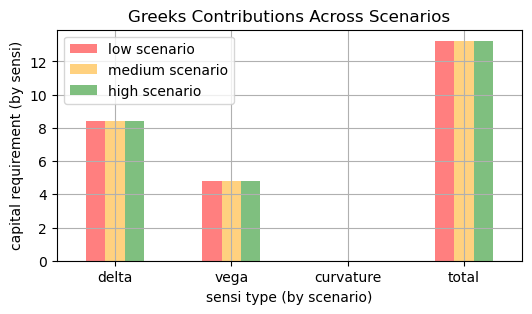

In [12]:
# params of position - Long call
S = 80     # Current stock price
K = 100     # Strike price
T = 1/12       # Time to maturity in years
r = 0.05    # Risk-free interest rate
sigma = 0.3 # Volatility
bucket = 8
size = 1 # for 1 long position of the instrument

# IMPORTANT : any option formula will work so long as it takes inputs (in the exact order) : Spot, Repo, Implied_Vol
Vi = lambda S, repo, sigma: black_scholes_call(S, sigma, K=100, T=0.5, r=0.05)
position_i = {'pricer':Vi, 'S':S, 'repo':np.nan, 'sigma':sigma, 'option_term':T, 'bucket':bucket, 'name' : 'TSLA', 'size' : size}
L_rf = get_RF_instrument(position_i)
cap_req = get_capital_requirements(L_rf)

def plot_cap_req(cap_req):
    cap_req.plot(kind='bar', figsize=(6, 3), color=['red', 'orange', 'green'], alpha=0.5, grid=True)
    plt.title('Greeks Contributions Across Scenarios')
    plt.xlabel('sensi type (by scenario)')
    plt.ylabel('capital requirement (by sensi)')
    plt.xticks(rotation=0)  # Rotate labels to be horizontal
    plt.show()

plot_cap_req(cap_req)


### <a id="section11"></a> 9.2) Portfolio 2 : short call 
<u>Outcome analysis: </u>
- Unlike portfolio 1 (ie: long call), the curvature capital charge is significant. Short options have negative vega, which decrease PnL, or increase losses/exposure.

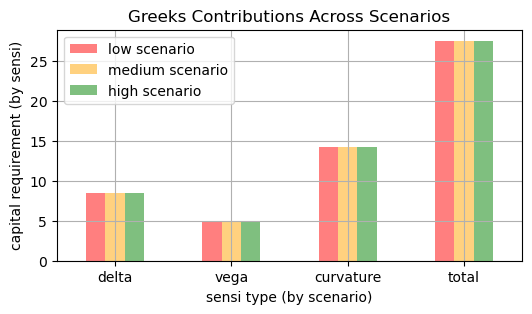

In [13]:
# params of position - short call
S, K, T, r, sigma, bucket = 80, 100, 1/12, 0.05, 0.3, 8
size = -1 # short
Vi = lambda S, repo, sigma: black_scholes_call(S, sigma, K=100, T=0.5, r=0.05)
position_i = {'pricer':Vi, 'S':S, 'repo':np.nan, 'sigma':sigma, 'option_term':T, 'bucket':bucket, 'name' : 'TSLA', 'size' : size}

# decompose positioin into RFs
L_rf = get_RF_instrument(position_i)
# compute capital requirements 
cap_req = get_capital_requirements(L_rf)

plot_cap_req(cap_req)

### <a id="section12"></a> 9.3) Portfolio 3 : long call (BNP) , long call (SG) 
<u>Outcome analysis: </u>
- across all greeks, we obtain higher capital requirements the higher the correlation scenarios. This is expected since in a LONG ONLY portfolio, the only means of mitigating risk is through diversification. 
=> There is a diversification benefit that comes from lower correlation.

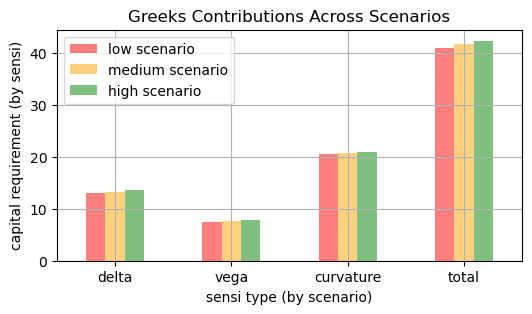

In [14]:
# params of position 
S, K, T, r, sigma, bucket = 80, 100, 1/12, 0.05, 0.3, 8
size = -1 # short
Vi = lambda S, repo, sigma: black_scholes_call(S, sigma, K=100, T=0.5, r=0.05)
positions = [[Vi, S, np.nan, sigma, T, bucket, 'BNP',  size], 
             [Vi, S, np.nan, sigma, T, bucket, 'SG',  size]]
# decompose positioin into RFs
L_rf = [rf for posi in positions for rf in get_RF_instrument(posi)]
# compute capital requirements 
cap_req = get_capital_requirements(L_rf)
plot_cap_req(cap_req)

cap_req3 = cap_req

### <a id="section13"></a> 9.4) Portfolio 4 : long call (BNP) ,short call (SG) 
<u>Outcome analysis: </u>
- Most notably we notice that the correlation scenario is more punitive (in terms of capital requirements) when the systemic correlation parametor is low. This is expected since the 2 positions are identical in all regards besides direction (ie: long vs short). This si because the higher the correlation, the better the positions offset each other =>  In other words, there is a hedging benefit that comes from higher correlation. 

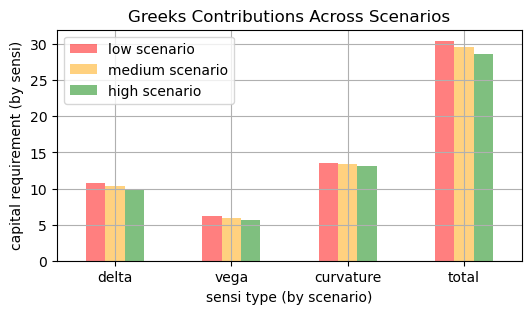

In [15]:
# params of position 
S, K, T, r, sigma, bucket = 80, 100, 1/12, 0.05, 0.3, 8
#size = -1 # short
Vi = lambda S, repo, sigma: black_scholes_call(S, sigma, K=100, T=0.5, r=0.05)
positions = [[Vi, S, np.nan, sigma, T, bucket, 'BNP',  1], 
             [Vi, S, np.nan, sigma, T, bucket, 'SG',  -1]]
# decompose positioin into RFs
L_rf = [rf for posi in positions for rf in get_RF_instrument(posi)]
# compute capital requirements 
cap_req = get_capital_requirements(L_rf)

plot_cap_req(cap_req)


### <a id="section14"></a> 9.5) Portfolio 5 : long call (BNP) ,long call (TOTAL) 
<u>Outcome analysis: </u>
- recall portfolio 3 : long call(BNP), long call (SG)
- In comparing portfolio 5 and portfolio 3 we notice reduced capital charge across all greeks. 
- this is expected since underlying of portfolio 3 are more similar (BNP and SG: both in bucket 8) whilst those in portfolio 5 are from different buckets (bucket 8 and 7)
- in a long only portfolio, diversification reduces volatility, hence the more different the underlying (or equivalently the lower the correlation), the higher the diversification benefits.
- This highlights the fact that inter bucket correlation are more beneficial than intra bucket correlations

In [16]:
# params of position 
S, K, T, r, sigma = 80, 100, 1/12, 0.05, 0.3

Vi = lambda S, repo, sigma: black_scholes_call(S, sigma, K=100, T=0.5, r=0.05)
positions = [[Vi, S, np.nan, sigma, T, 8, 'BNP',  1], 
             [Vi, S, np.nan, sigma, T, 7, 'TTL',  1]]
# decompose positioin into RFs
L_rf = [rf for posi in positions for rf in get_RF_instrument(posi)]
# compute capital requirements 
cap_req = get_capital_requirements(L_rf)
#plot_cap_req(cap_req)

print("Portofolio 5 (long call(BNP), long call(TOTAL)) : \n\n",cap_req)
print("\n\nPortofolio 3 (long call(BNP), long call(SG)) : \n\n",cap_req3)
print("\n\nPortfolio 5 VS Portofolio 3 : \n\n", cap_req - cap_req3)

Portofolio 5 (long call(BNP), long call(TOTAL)) : 

            low scenario  medium scenario  high scenario
delta         11.363277        11.549065      11.731912
vega           7.198702         7.319023       7.437398
curvature      0.000000         0.000000       0.000000
total         18.561980        18.868089      19.169309


Portofolio 3 (long call(BNP), long call(SG)) : 

            low scenario  medium scenario  high scenario
delta         12.980748        13.317966      13.646855
vega           7.437398         7.630609       7.819048
curvature     20.653958        20.807521      20.959959
total         41.072104        41.756096      42.425861


Portfolio 5 VS Portofolio 3 : 

            low scenario  medium scenario  high scenario
delta         -1.617471        -1.768901      -1.914943
vega          -0.238696        -0.311586      -0.381650
curvature    -20.653958       -20.807521     -20.959959
total        -22.510124       -22.888008     -23.256552
